# Strategy Introduction
This strategy is a CTA cross-sectional strategy. A CTA cross-sectional strategy is a quantitative investment strategy commonly used in futures and forex markets, aiming to gain profits by analyzing and trading multiple assets or contracts. The core idea of this strategy is to analyze and rank the performance of different assets, constructing a diversified investment portfolio to achieve risk diversification and maximize returns.
<br/><br/>This strategy primarily uses return momentum and volatility factors, mainly selecting the top and bottom ten percent of assets for trading, and adjusting positions based on volatility.
<br/><br/>The strategy steps are divided into the following parts: contract data acquisition, N-day return momentum calculation and return ranking, signal setting, weighted calculation of return and volatility signals, backtest calculation, and margin ratio calculation.
<br/><br/>The non-code part of this strategy will first introduce relevant concepts in text, then use mathematics to demonstrate the calculation of these concepts, and finally integrate the previous content with code explanations.

# Contract Data Collection
This section primarily involves importing relevant data packages and using API interfaces.
<br/><br/>The Quantitative Trading API interface is a programming interface that allows developers to access and manipulate financial market data and perform trading operations programmatically. Numpy, Pandas, and matplotlib are the three most fundamental data analysis packages in Python, while jqdata is the API interface provided by JoinQuant. Datetime and Seaborn are used for time index settings and statistical plotting, respectively.
<br/><br/>First, we import all the necessary data packages and then set the start and end times. After that, we put all the currently traded commodities into the constituents list.
The calculation of the start time is as follows:
<br/><br/>
$$ \text{Start Date} = \text{Current Time} - \text{Time Delta} $$ 
<br/><br/>Then use `.date()` to convert it into "datetime.date" type data for use as the index in the dataframe. Then use the API function to get the trading days. Finally, input the commodities to be traded and place them into the constituents.
<br/><br/>Meanwhile, the holding period can be set here. In holding_period, the `holding period` can be set to 5 trading days.

In [1]:
# This part is the cross-sectional momentum strategy codes:

# Import relevant libraires and data from the API interface
import pandas as pd 
import numpy as np
from jqdata import *
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns

startdate = '2016-4-15'#(datetime.now() - timedelta(days=3000)).date()
end_date = datetime.now()

tdays = get_trade_days(start_date = startdate, end_date = end_date, count=None)
holding_period = 6
# sliced tdays

constituents = ['IC8888.CCFX', 'IF8888.CCFX', 'IH8888.CCFX', 'IM8888.CCFX', 'T8888.CCFX', 'TF8888.CCFX', 'TS8888.CCFX',
               'SC8888.XINE', 'NR8888.XINE', 'LU8888.XINE', 'BC8888.XINE','RM8888.XZCE', 'EC8888.XINE', 'SH8888.XZCE', 'PX8888.XZCE',
               'AG8888.XSGE', 'AL8888.XSGE', 'AU8888.XSGE', 'BU8888.XSGE', 'CU8888.XSGE', 'FU8888.XSGE', 'HC8888.XSGE', 'NI8888.XSGE', 'PB8888.XSGE', 'RB8888.XSGE', 'RU8888.XSGE', 'SN8888.XSGE', 'WR8888.XSGE', 'ZN8888.XSGE', 'SP8888.XSGE', 'SS8888.XSGE', 
               'AP8888.XZCE', 'CF8888.XZCE', 'CY8888.XZCE', 'FG8888.XZCE', 'MA8888.XZCE', 'OI8888.XZCE', 'RS8888.XZCE', 'SF8888.XZCE', 'SM8888.XZCE', 'SR8888.XZCE', 'TA8888.XZCE', 'CJ8888.XZCE', 'UR8888.XZCE', 'SA8888.XZCE', 'PF8888.XZCE', 'PK8888.XZCE',
               'A8888.XDCE', 'B8888.XDCE', 'BB8888.XDCE', 'C8888.XDCE', 'CS8888.XDCE', 'FB8888.XDCE', 'I8888.XDCE', 'J8888.XDCE', 'JD8888.XDCE', 'JM8888.XDCE', 'L8888.XDCE', 'M8888.XDCE', 'P8888.XDCE', 'PP8888.XDCE', 'V8888.XDCE', 'Y8888.XDCE', 'EG8888.XDCE', 'EB8888.XDCE', 'PG8888.XDCE', 'LH8888.XDCE', 'RR8888.XDCE',
               'SI8888.GFEX', 'BR8888.XSGE', 'AO8888.XSGE', 'TL8888.CCFX', 'LC8888.GFEX']

# N-Day Return Momentum Calculation and Return Ranking

Here, we set N to 7 (trading days). By using the API's function to obtain closing prices, we can acquire the historical closing price data for each contract. Then, we calculate the return for each commodity over 7 trading days.
<br/><br/>At the same time, we also obtain opening prices to calculate the opening prices, using closing prices to calculate the closing prices. We add the futures company commission fees together to get the total transaction cost, which will be used later in the return calculation.
<br/><br/>Next, we sort the daily rise and fall amplitude data of the commodities. Finally, we extract the last row of data to view the ranking example.
<br/><br/>The specific formula for calculating the past N-day returns`past_N_days_returns`is:<br/><br/> $$
R_{t,n} = \frac{P_{t-1} - P_{t-(n+1)}}{P_{t-(n+1)}} $$
<br/><br/>where $t$ is the specified date, $n$ is the number of past days, $P$ is the price, and $R$ is the return.

In [2]:
# To set the period of calculating the price increase & decrease percentage as three
N = [6]

daily_returns = pd.DataFrame(columns = N, index = tdays)

close_series = get_price(constituents, start_date= startdate ,
                         end_date= end_date,
          fields=['close'], skip_paused=False, fq='pre', frequency = '1d', count=None)['close']

open_series = get_price(constituents, start_date= startdate ,
                         end_date= end_date,
          fields=['open'], skip_paused=False, fq='pre', frequency = '1d', count=None)['open']

# Trading cost: 1/3000 of the opening price and 1/3000 of the closing price
entry_commission = 1/3000 * open_series
exit_commission = 1/3000 * close_series
futures_account_commission = (entry_commission + exit_commission) * 1/100
trading_cost = entry_commission + exit_commission + futures_account_commission
close_series_pct = (trading_cost / close_series).shift(-1*holding_period)


# Calculate the series of price increase and decrease within 7 days
for n in N:
    past_N_days_returns = (close_series.shift(1) - close_series.shift(n+1)) / close_series.shift(n+1)

# Rank the commodity contracts based on their 7-day returns

past_N_days_returns_0 = past_N_days_returns.fillna(0)
returns_rank = past_N_days_returns_0.rank(axis=1)
total_rank = returns_rank.shape[1]

#Create an empty dataframe
returns_rank_df = pd.DataFrame()
returns_rank_df['returns'] = past_N_days_returns_0.iloc[-1:,].squeeze()
returns_rank_df['rank'] = returns_rank.iloc[-1:,].squeeze()
returns_rank_df.sort_values("rank")

/opt/conda/lib/python3.6/site-packages/jqdata/apis/data.py:168: UserWarning: 不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），建议 get_price 传入 panel=False 参数
  warnings.warn("不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），"
/opt/conda/lib/python3.6/site-packages/jqresearch/api.py:120: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  round=round)
/opt/conda/lib/python3.6/site-packages/jqdata/apis/data.py:168: UserWarning: 不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），建议 get_price 传入 panel=False 参数
  warnings.warn("不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），"


,returns,rank
AG8888.XSGE,-0.092111,1.0
EC8888.XINE,-0.075715,2.0
SN8888.XSGE,-0.073853,3.0
SH8888.XZCE,-0.061472,4.0
SA8888.XZCE,-0.058797,5.0
BC8888.XINE,-0.057876,6.0
J8888.XDCE,-0.057494,7.0
FU8888.XSGE,-0.056842,8.0
CU8888.XSGE,-0.055806,9.0
WR8888.XSGE,-0.054846,10.0


# Signal Settings
Here, the total ranking count is used for calculations. The total ranking count is 73, and then the top and bottom varieties within 3 deciles are selected for trading. For `signal`, the closer to the top or bottom, the stronger the trading signal. Each layer of the signal includes 7 varieties. The `signal_1` only represents the trading direction and will be used in the calculation of the returns for the held varieties.

<br/>The logical steps for setting signals in this section are:

1. Set the basic holding signal. Each variety's specific ranking is divided into three layers - positive and negative 1, 10, 100 (positive for long, negative for short). Each layer contains seven varieties. The larger the absolute number, the stronger the positive trading signal, indicating a higher proportion of buying or selling. This is used for the volatility-based holding calculation later (primarily trading the varieties with high momentum in returns, with the second and third last decile varieties smoothing the curve).
2. Set the returns signal. Select the top and bottom varieties within 3 deciles for long and short signal settings, with only positive and negative 1. This is used to calculate the value of returns for long and short positions.
3. Set all non-traded varieties to 0.
4. Use correlation values for signal filtering and switching. If the correlation coefficient R value of the price changes between two varieties exceeds 0.65, they are considered highly correlated. The variety with the lower absolute price change is filtered out, and its signal is weakened. The variety with the closest ranking and lower absolute price change has its signal strengthened, completing a trade switch.







## Setting Basic Positions and Return Signals

In [3]:
# Here we can generate some trading singals, top and bottom decimiles possess stronger signals
# Assuming that we have different levels of confidence in different contracts,
# we can trade more contracts with more obvious price increases and decreases


num_1 = 100 
num_2 = 10 
num_3 = 1

def long_or_short(rank):
    if  total_rank*2/10 < rank < total_rank*3/10:
        return - num_3 
    elif total_rank*1/10 < rank < total_rank*2/10:
        return - num_2
    elif 0 < rank < total_rank*1/10:
        return - num_1
    elif total_rank*7/10 < rank < total_rank*8/10:
        return num_3
    elif total_rank*8/10 < rank < total_rank*9/10:
        return num_2
    elif total_rank*9/10 < rank < total_rank:
        return num_1
    else:
        return 0

    return rank

def long_or_short_1(rank):
    if  0 < rank < total_rank*3/10:
        return -1  
    if total_rank*7/10 < rank < total_rank:
        return 1
    else:
        return 0
    
    return rank

signal = returns_rank.applymap(long_or_short)
signal_1 = returns_rank.applymap(long_or_short_1)

## Correlation Calculation and Display
This section involves the calculation of correlation and the display of the correlation heatmap. The holding period is set to 5 trading days, and the percentage change in closing prices over the holding period is calculated to determine the correlation between the prices of various contract types. These results will be used for subsequent signal filtering and switching based on correlation. The formula for calculating the Pearson correlation coefficient $R$ is as follows:<br/>
$$
R = \frac{\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}{\sqrt{n \sigma_{x}^{2}} \sqrt{n \sigma_{y}^{2}}}
$$
<br/>
$R$: The Pearson correlation coefficient, a statistical measure of the strength and direction of the linear relationship between two variables.
$n$: The number of samples, i.e., the total number of data points.

$x_i$: The $i$-th sample point's $x$ value.

$\overline{x}$: The mean of the $x$ sample data, calculated as $\overline{x} = \frac{1}{n} \sum_{i=1}^{n} x_i$.

$y_i$: The $i$-th sample point's $y$ value.

$\overline{y}$: The mean of the $y$ sample data, calculated as $\overline{y} = \frac{1}{n} \sum_{i=1}^{n} y_i$.

$\sigma_{x}^{2}$: The variance of the $x$ sample data, calculated as $\sigma_{x}^{2} = \frac{1}{n} \sum_{i=1}^{n} (x_i - \overline{x})^2$.

$\sigma_{y}^{2}$: The variance of the $y$ sample data, calculated as $\sigma_{y}^{2} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \overline{y})^2$.

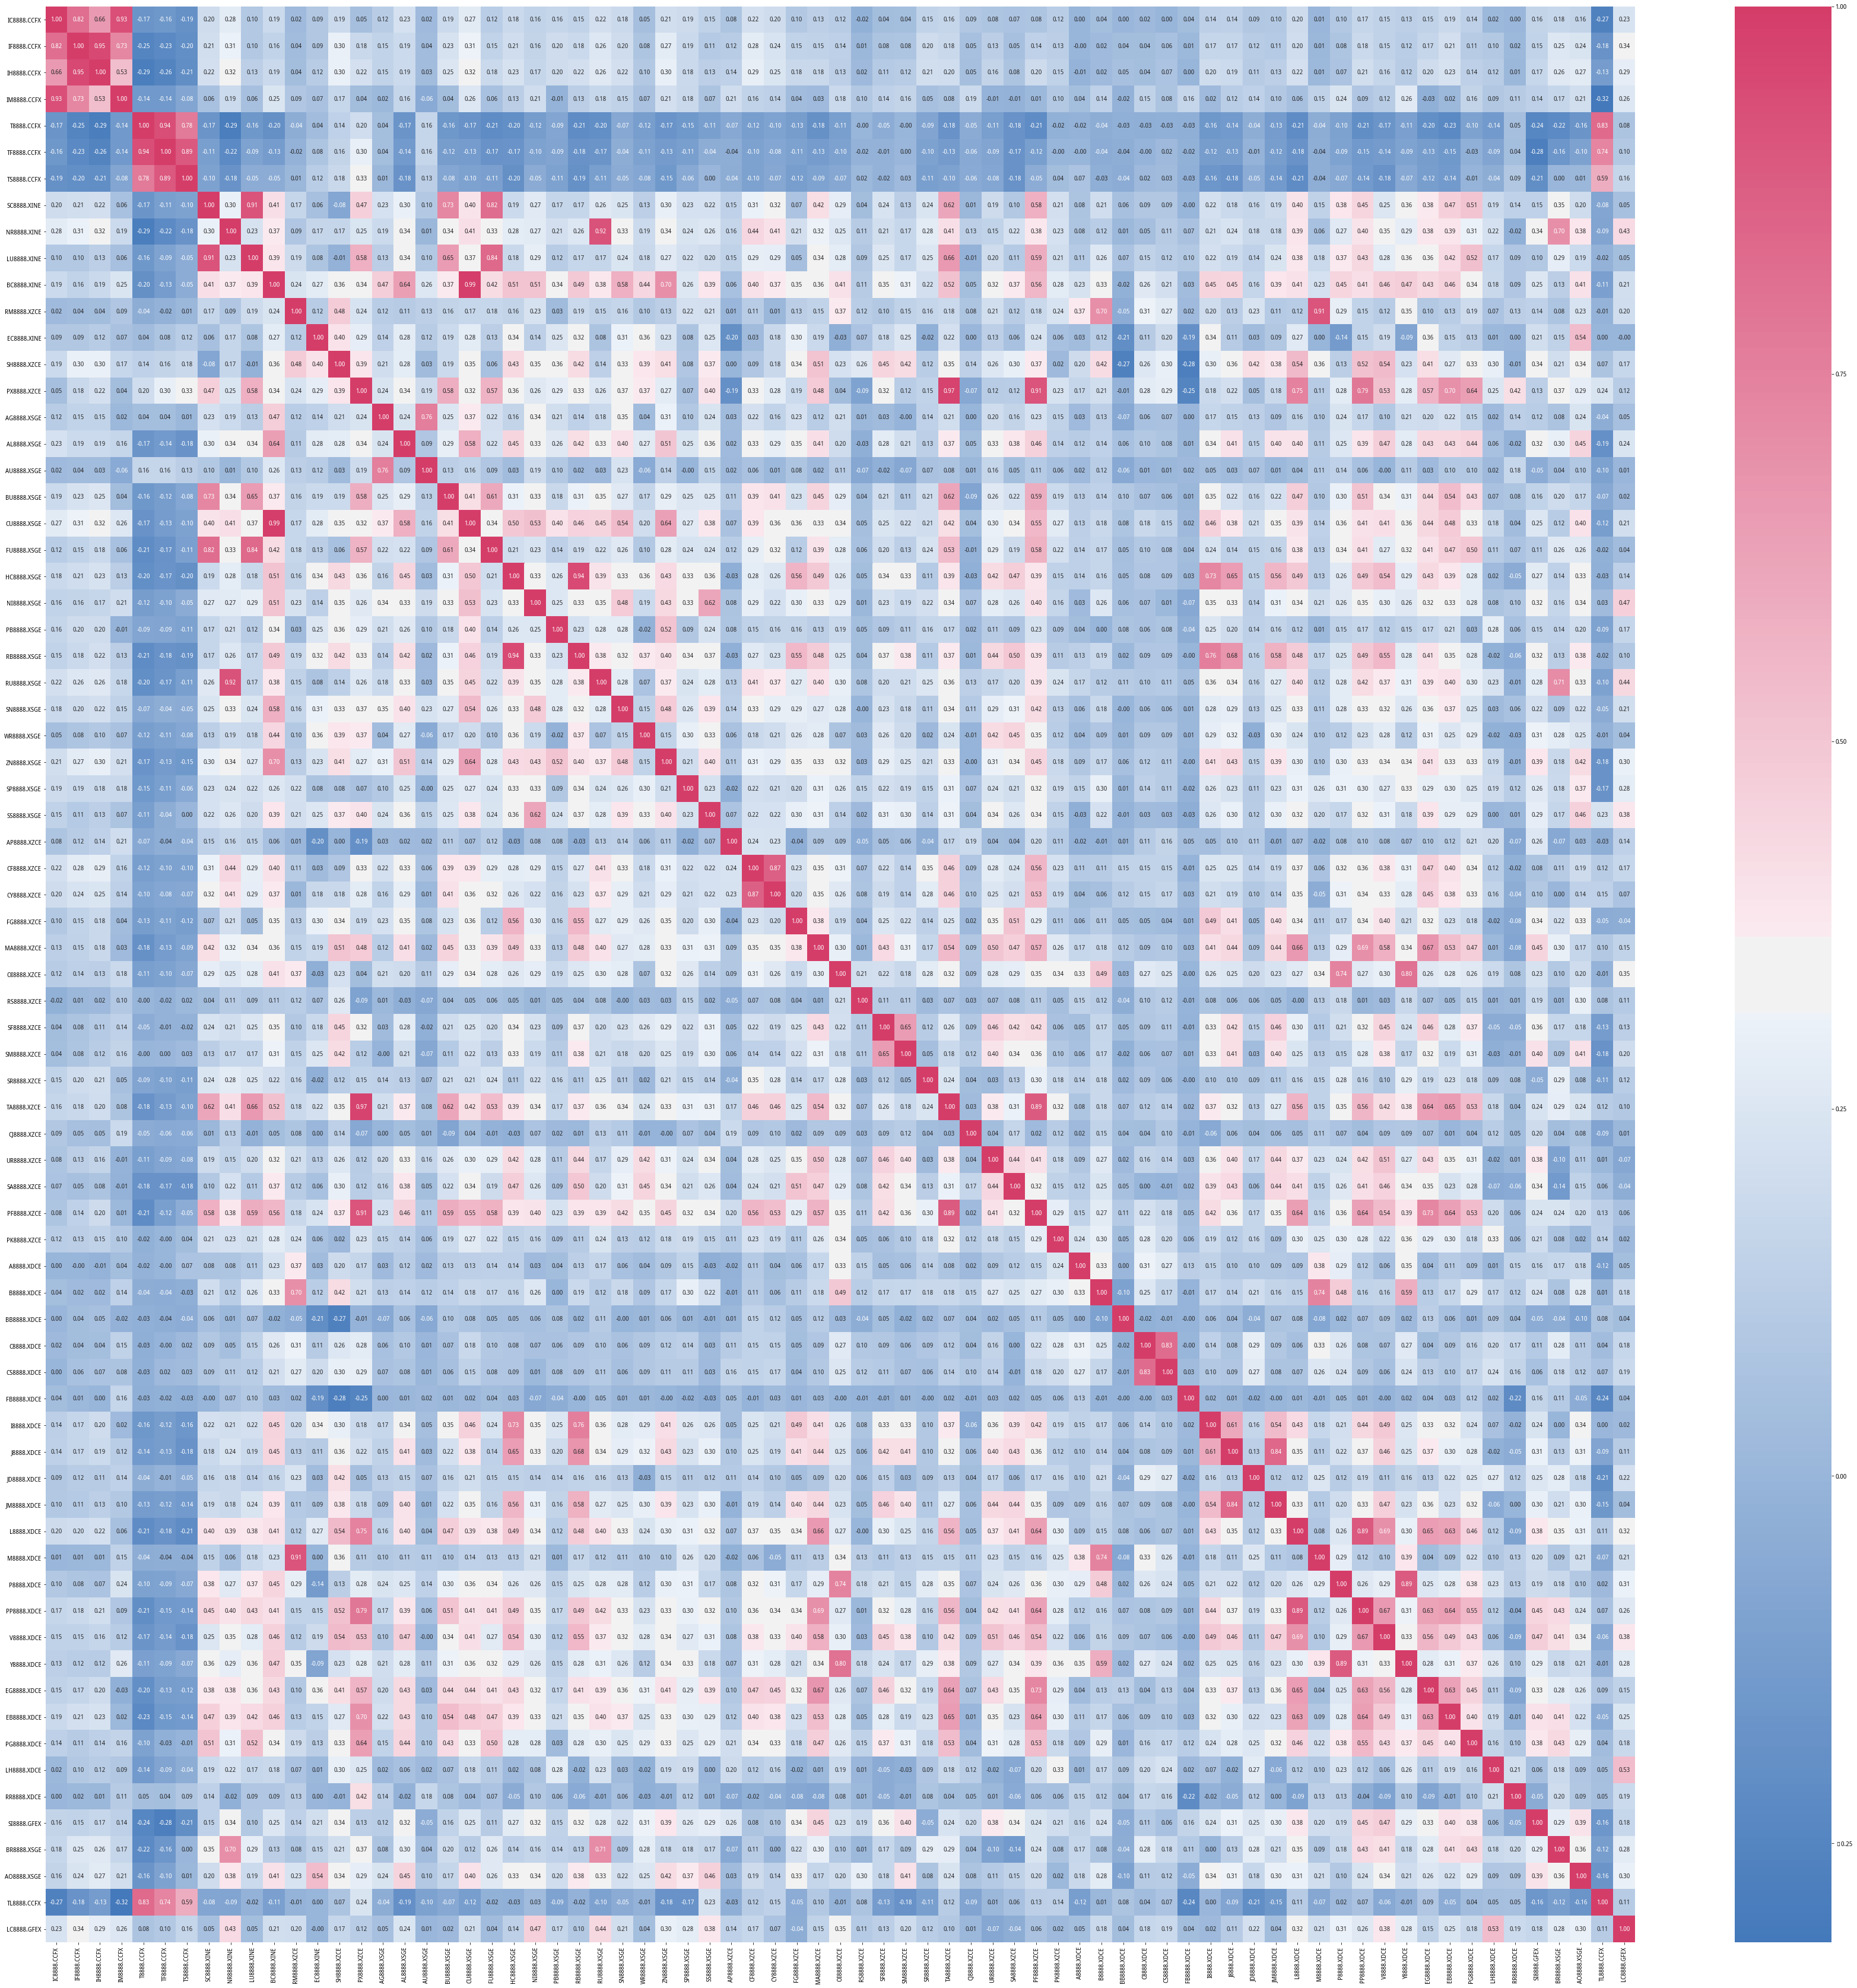

In [4]:
holding_period_returns = past_N_days_returns.shift(-1*holding_period)
contract_correlation = holding_period_returns.corr()

# Generate the heatmap of the correlations of different contract pairs

plt.figure(figsize=(60,60))
sns.heatmap(data=contract_correlation,annot=True,fmt=".2f",cmap=sns.diverging_palette(250, 0, as_cmap=True))
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## Signal Filtering and Switching Using Correlation Values
Here, we first set the correlation threshold to 0.6, indicating that a return change correlation as high as 60% signifies high correlation. In this scenario, trading simultaneously increases the risk of drawdown. Therefore, signal restriction should be applied appropriately, or even switch to trading less correlated assets. To avoid large risk exposure, we will directly switch trading assets after position limitation. For simplicity in strategy demonstration, we perform signal filtering and switching based on correlation only once per day. Theoretically, this would be done in multiple rounds until the correlation of all trading assets is below 0.6.

After setting the threshold and placing all highly correlated asset combinations into a list, the strategy will, for each trading day, compare the returns of each highly correlated combination in `holding_period_returns`. If the two assets in the combination are both among the top or bottom decile trading assets on a certain trading day (i.e., their signal absolute value is 90), the asset with the weaker price movement will be filtered out for signal weakening, while the asset closest in rank to the filtered asset from the second-to-last decile will be selected for signal strengthening.

In [5]:
import math

correlation_threshold = 0.6
high_correlation_pairs = contract_correlation.stack().loc[lambda x: (x > correlation_threshold) & (x < 1)]
high_corr_pairs = high_correlation_pairs.index.tolist()

# For each day in 'signal', choose the weaker targets in high correlation paris and weaken their signals.
# Then choose the most approximate new weaker targets with the least aboslute return difference compared to the previsouly chosen weaker targets,
# and intensify the signals of the new weaker targets

for date in signal.index:
    for (item1, item2) in high_corr_pairs:
        if signal.at[date, item1] == num_1  and signal.at[date, item2] == num_1 :
            if holding_period_returns.at[date, item1] < holding_period_returns.at[date, item2]:
                signal.at[date, item1] = num_2
                for item in signal.columns.tolist():
                    if (item2, item) not in high_corr_pairs:
                        if returns_rank.at[date, item] == min(returns_rank.loc[date], key=lambda x: abs(x - math.ceil(total_rank - (1/10 * total_rank)))):
                            signal.at[date, item] = num_1
            else:
                signal.at[date, item2] = num_2
                for item in signal.columns.tolist():
                    if (item1, item) not in high_corr_pairs:
                        if returns_rank.at[date, item] == min(returns_rank.loc[date], key=lambda x: abs(x - math.ceil(total_rank - (1/10 * total_rank)))):
                            signal.at[date, item] = num_1
        
            if signal.at[date, item1] == -num_1 and signal.at[date, item2] == -num_1 :
                if holding_period_returns.at[date, item1] > holding_period_returns.at[date, item2]:
                    signal.at[date, item1] = -num_2
                    if (item2, item) not in high_corr_pairs:
                        if returns_rank.at[date, item] == min(returns_rank.loc[date], key=lambda x: abs(x - math.floor(1 + (1/10 * total_rank)))):
                            signal.at[date, item] = -num_1
                else:
                    signal.at[date, item2] = -num_2
                    if (item1, item) not in high_corr_pairs:
                        if returns_rank.at[date, item] == min(returns_rank.loc[date], key=lambda x: abs(x - math.floor(1 + (1/10 * total_rank)))):
                            signal.at[date, item] = -num_1

# Calculation of Returns and Volatility Signal Weighting
First, we derive the volatility. Using various conditional clauses, we process the volatility data. Next, we incorporate `signal` and multiply it by the volatility over each 7-trading-day period to obtain the volatility adjusted by the weights of the traded instruments for each day. Finally, we use the inverse of the volatility for position calculation and incorporate `signal_1` and `holding_period_returns` to determine the returns corresponding to the long and short trading directions every 7 trading days.

<br/>
The formula for calculating volatility is:
$$
\sigma = \sqrt{\frac{\sum_{i=1}^{n} (r_i - \overline{r})^2}{n-1}}
$$
<br/>
where $\sigma$ represents price volatility, $r_i$ represents the return on the $i$-th day, $\overline{r}$ represents the mean of the returns, and $n$ represents the number of return data points.
<br/>

The formula for calculating positions based on volatility is：
$$
Position_i = \frac{\frac{1}{\sigma_i}}{\sum_{j=1}^{N} \frac{1}{\sigma_j}}
$$
<br/>
where:
$Position_i$ represents the position proportion of the $i$-th asset, $\sigma_i$ represents the volatility of the $i$-th asset, and $N$ represents the total number of assets.
<br/>
In the final stage, the return adjusted for the holding period, `holding_period_returns_with_intervals`, will subtract the transaction costs `close_series_pct` to reflect a more realistic return.


In [6]:
# Sift contracts. For those with too low volatility, we screen them out
# Then we choose the commodity contracts within top decimiles 

returns = close_series.pct_change()

std = returns.rolling(window=holding_period).std()

def filters(x):
    # This is to remove the contracts with abnormal volatlity, the criterion is bond volatility
    if x > 0.0001: 
        return 1 / x
    else:
        return 0

volatility = std.applymap(filters)

# Calculate futures volatility between holding periods. This is done by jumping the number of holding days

adjusted_volatility = volatility[::holding_period] * signal [::holding_period]
adjusted_volatility = adjusted_volatility.abs()
def vola_calculation(x):
    if (x > 0).any():
        return x/x.sum() 
    else:
        return x
        
positions = adjusted_volatility.apply(vola_calculation,axis=1) 

# Calculate futures returns between holding periods. This is done by jumping the number of holding days

holding_period_returns_with_intervals = (holding_period_returns[::holding_period] * signal_1 [::holding_period]) - (close_series_pct[::holding_period]).shift(1)

# Backtest
The final section includes net value backtest images, Sharpe ratio calculations, drawdown images, and margin ratios. Here, the commodity fund index and the strategy itself will be compared.
<br/>

## Net Asset Value (NAV) and Sharpe Ratio Calculation

In the NAV calculation, the first step is to multiply the returns and holding data for each 7-day trading period to obtain the weighted holding period return `adjusted_holding_period_returns`. Then, sum up the returns for each period to get the total daily return (`.sum(axis=1)` calculates each row, i.e., the daily total return. Typically, if there's no data for the most recent day, it's just truncated). Based on the NAV calculation formula, calculate the strategy's NAV using the portfolio returns `portfolio_returns`. Finally, calculate the strategy's Sharpe ratio (i.e., the excess return per unit of risk) according to the formula.
<br/>

NAV refers to the total asset value of a fund or portfolio minus the total liabilities at a specific point in time, usually expressed per unit (e.g., per share or per unit). It reflects the current market value of the investment and is an important indicator of the performance of a fund or portfolio.
<br/>
The Sharpe ratio, proposed by William Sharpe, is an indicator used to measure the risk-adjusted return of a portfolio. It reflects the excess return obtained per unit of risk.
<br/>

The NAV calculation formula is as follows:
<br/>
$$
NV_{t} = NV_{0} \prod_{i=1}^{t} \left(1 + \sum_{j=1}^{n} r_{i,j} \cdot Position_{i,j} \right)
$$
<br/>

Assume:

- $R_{t}$ represents the return of the portfolio in period $t$.
- $NV_{t}$ represents the NAV in period $t$.
- The initial NAV $NV_{0} = 1$.
The NAV calculation formula is:：

$$
NV_{t} = NV_{0} \prod_{i=1}^{t} (1 + R_{i})
$$

Where:

- $R_{t}$ is the portfolio return in period $t$, represented as:：

$$
R_{t} = \sum_{j=1}^{n} r_{t,j} \cdot Position_{t,j}
$$

Where:

- $r_{t,j}$ represents the holding period return of asset $j$ in period $t$.
- $Position_{t,j}$ represents the holding proportion of asset $j$ in period $t$.
Therefore, the NAV calculation formula can be expressed as:：

$$
NV_{t} = NV_{0} \prod_{t=1}^{t} \left(1 + \sum_{j=1}^{n} r_{t,j} \cdot Position_{t,j} \right)
$$
<br/>

The Sharpe ratio calculation formula is as follows
<br/>

Assume：
- $R_p$ represents the average return of the portfolio.
- $\sigma_p$ represents the standard deviation of the portfolio return.
- $T$ represents the number of trading periods in a year (typically 252 days).

The annualized Sharpe ratio formula is：

$$
S = \frac{\frac{\sum_{t=1}^{n} R_{t}}{n}}{\sqrt{\frac{\sum_{t=1}^{n} (R_{t} - \overline{R})^2}{n-1}}} \times \sqrt{T}
$$

Where:
- $R_{i}$ represents the return of the portfolio in period $i$.
- $\overline{R}$ represents the average return of the portfolio.
- $n$ represents the number of periods in the total return time frame.


In [7]:
commodity_fund_idx = pd.read_excel('Commodity Fund Index.xlsx')
commodity_fund_idx.set_index(commodity_fund_idx.columns[0],inplace=True)
Z = [1]
for z in Z:
    commodity_fund_idx_chg = (commodity_fund_idx.shift(1) - commodity_fund_idx.shift(z+1)) / commodity_fund_idx.shift(z+1)

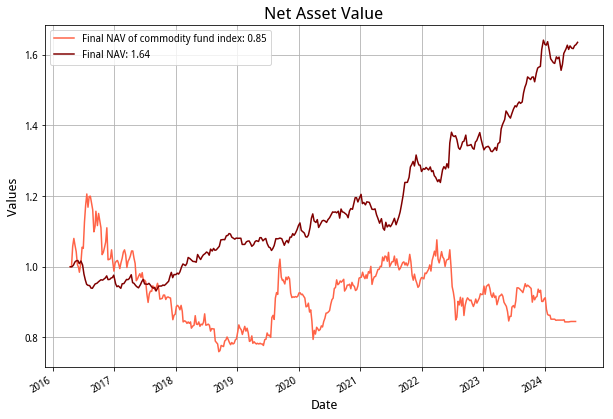

Sharpe of the strategy: 0.97
Sharpe of the commodity fund index: -0.06


In [8]:
# Backtesting

# Net asset value of the strategy and the index

adjusted_holding_period_returns = holding_period_returns_with_intervals * positions
portfolio_returns = adjusted_holding_period_returns.sum(axis=1).iloc[:-1]
commodity_fund_idx_returns = commodity_fund_idx_chg.iloc[:,0].fillna(0) 
    
plt.figure(figsize=(10,7))
plt.title("Net Asset Value",fontsize=17)
plt.xlabel("Date",fontsize=13)
plt.ylabel("Values",fontsize=13)
(commodity_fund_idx_returns+1).cumprod(axis=0).plot(grid=True, color='tomato',label='Final NAV of commodity fund index: {:.2f}'.format((commodity_fund_idx_returns+1).prod()))
(portfolio_returns+1).cumprod(axis=0).plot(grid=True, color='maroon',label='Final NAV: {:.2f}'.format((portfolio_returns+1).prod()))
plt.legend()
plt.show()

print("Sharpe of the strategy: {:.2f}".format((portfolio_returns.mean()/portfolio_returns.std())*(252/holding_period)**0.5))
print("Sharpe of the commodity fund index: {:.2f}".format((commodity_fund_idx_returns.mean()/commodity_fund_idx_returns.std())*(252/holding_period)**0.5))


## Drawdown Calculation
In the drawdown calculation, we first define the net value `NV` based on previous data. Then, we use `np.maximum.accumulate()` to calculate the maximum net value up to the current time point, forming a sequence of the same length as the net value sequence. To ensure the maximum value is not less than 1, any maximum value less than 1 is adjusted to 1 to avoid negative values when calculating the drawdown. Finally, the minimum value in the drawdown is found as the maximum drawdown and converted to a percentage.
<br/>

Drawdown refers to the decline in asset value from the highest point to the lowest point within an investment cycle, usually expressed as a percentage. It reflects the risk and loss situation during the investment process.
<br/>
The following are the formulas for calculating the drawdown.

### Drawdown Calculation Formula：
$$
DD_t = \frac{NV_t}{RM_t} - 1
$$

### Maximum Drawdown Calculation Formula：
$$
MDD = \min_{t} DD_t \times 100
$$

Where:
- $DD_t$ represents the drawdown in period $t$.
- $MDD$ represents the maximum drawdown, expressed as a percentage.
- $NV_t$ represents the net value in period $t$.
- $RM_t$ represents the running maximum value in period $t$.


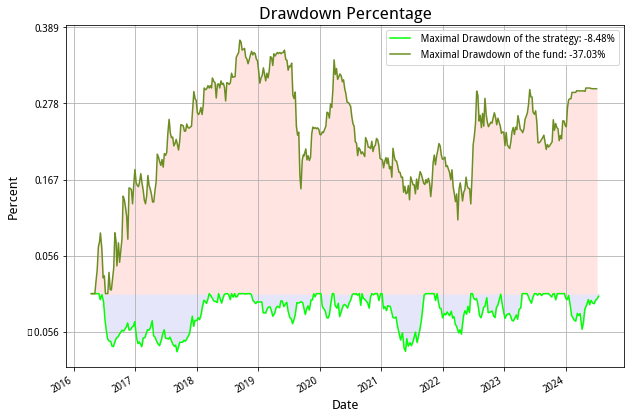

In [9]:
# Drawdown test
NV = (portfolio_returns+1).cumprod()
running_maximum = np.maximum.accumulate(NV)

for num in running_maximum:
    if num < 1:
        num = 1
    else:
        num = num

drawdown = ((NV / running_maximum) - 1)
max_drawdown = drawdown.min() * 100

NV_1 = (commodity_fund_idx_returns+1).cumprod()
running_maximum_1 = np.maximum.accumulate(NV_1)

for num in running_maximum_1:
    if num > 1:
        num = 1
    else:
        num = num

drawdown_1 = -((NV_1 / running_maximum_1) - 1)
max_drawdown_1 = drawdown_1.max() * 100

plt.title("Drawdown Percentage",fontsize=17)
plt.ylabel("Percent",fontsize=13)
plt.xlabel("Date",fontsize=13)
drawdown.plot(figsize = (10,7), grid = True, color = 'lime', label = " Maximal Drawdown of the strategy: {:.2f}%".format(max_drawdown))
drawdown_1.plot(figsize = (10,7), grid = True, color = 'olivedrab', label = " Maximal Drawdown of the fund: -{:.2f}%".format(max_drawdown_1))
plt.legend()
y_ticks = np.linspace(-0.5,0.5,10)
plt.yticks(y_ticks) 
plt.fill_between(drawdown.index, drawdown, color='lavender')
plt.fill_between(drawdown_1.index, drawdown_1, color='mistyrose')
plt.show()

## Margin Ratio
In futures trading, to ensure the fulfillment of contracts, both parties are required to pay a sum of money when opening a position. This sum serves as a performance guarantee to prevent the risk of default during the trading process. The purpose of the futures margin is to ensure the stable operation of the market and to prevent one party from failing to perform due to price fluctuations.
<br/><br/>
Here, we set the margin at 40% of the total amount, in millions. Finally, we calculate the total margin's fluctuation and plot it against the total funds of the strategy.

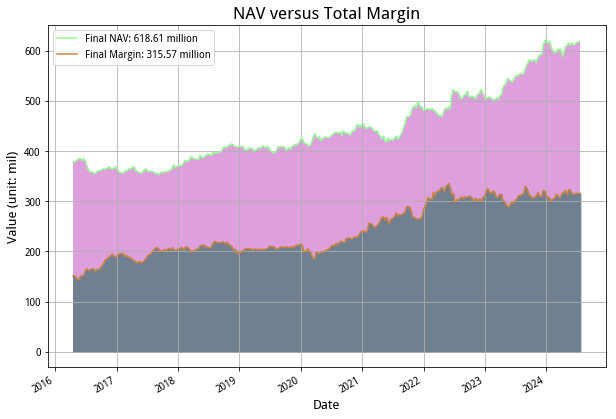

Largest margin ratio: 0.67
Smallest margin ratio: 0.39
Final margin ratio: 0.51


In [10]:
# Margin ratio
# Assuming that the initial capitaol is the sum of the first day margin multiplied by 100
# The initial total margin ratio is 0.4

units = pd.read_excel("futures_margin.xlsx", sheet_name="Contract Units")
margin_ratio = pd.read_excel("futures_margin.xlsx", sheet_name="Margin Ratio")

daily_margin_amount = margin_ratio * units * open_series
daily_margin_chg = daily_margin_amount.pct_change(periods=holding_period)
daily_margin_change = (daily_margin_chg[::holding_period].shift(-1)) * positions

daily_margin_sum = daily_margin_change.sum(axis=1)
adjusted_daily_margin = (margin_ratio * units * open_series * positions.shift(-1*holding_period)).sum(axis=1) 
initial_capital = (adjusted_daily_margin.iloc[0] / 0.4) / 100
total_margin_day_1 = initial_capital * 0.4

# New Net Asset Value and the daily total margin
NAV = ((portfolio_returns+1).cumprod(axis=0)) * initial_capital
total_margin = ((daily_margin_sum+1).cumprod(axis=0)) * total_margin_day_1

NAV.plot(figsize=(10,7),grid=True, color='palegreen',label='Final NAV: {:.2f} million'.format(((portfolio_returns+1).prod())*initial_capital))
total_margin.plot(figsize=(10,7),grid=True, color='peru',label='Final Margin: {:.2f} million'.format(((daily_margin_sum+1).prod())*total_margin_day_1))
plt.fill_between(NAV.index,NAV, color='plum')
plt.fill_between(total_margin.index, total_margin, color='slategray')
plt.title("NAV versus Total Margin",fontsize=17)
plt.ylabel("Value (unit: mil)",fontsize=13)
plt.xlabel("Date",fontsize=13)
plt.legend()
plt.show()

running_maximum_NAV = np.maximum.accumulate(NAV)
running_maximum_margin = np.maximum.accumulate(total_margin)
largest_margin_ratio = (running_maximum_margin/running_maximum_NAV).max()
smallest_margin_ratio = (running_maximum_margin/running_maximum_NAV).min()
final_margin_ratio = (((daily_margin_sum+1).prod())*total_margin_day_1) / (((portfolio_returns+1).prod())*initial_capital)
print('Largest margin ratio: {:.2f}'.format(largest_margin_ratio))
print('Smallest margin ratio: {:.2f}'.format(smallest_margin_ratio))
print('Final margin ratio: {:.2f}'.format(final_margin_ratio))